#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 신경망 성능 개선하기

 **학습 목표:** 특성을 정규화하고 다양한 최적화 알고리즘을 적용하여 신경망의 성능을 높입니다.

**참고:** 이 실습에서 설명하는 최적화 방식은 신경망에 국한된 것이 아니며 대부분의 모델 유형을 개선하는 데 효과적입니다.

 ## 설정

우선 데이터를 로드합니다.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2623.4,536.1,1422.7,498.8,3.9,2.0
std,2.1,2.0,12.6,2113.5,413.2,1147.0,378.6,1.9,1.1
min,32.5,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.0,297.0,789.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2121.0,434.0,1166.5,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3142.0,646.2,1713.0,603.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.4,2692.3,547.4,1446.1,507.0,3.9,2.0
std,2.1,2.0,12.7,2331.3,440.6,1149.9,398.4,1.9,1.2
min,32.5,-124.3,2.0,2.0,2.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1463.8,296.0,791.8,280.8,2.6,1.5
50%,34.2,-118.5,29.0,2149.5,433.0,1167.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3174.0,654.2,1744.2,608.0,4.8,2.3
max,41.9,-114.6,52.0,37937.0,5471.0,16122.0,5189.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.6
std,116.3
min,15.0
25%,120.0
50%,180.1
75%,265.0
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.7
std,115.2
min,15.0
25%,118.8
50%,180.6
75%,265.1
max,500.0


 ## 신경망 학습

이제 신경망을 학습시킵니다.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 148.89
  period 01 : 132.17
  period 02 : 118.03
  period 03 : 108.07
  period 04 : 106.27
  period 05 : 108.21
  period 06 : 105.31
  period 07 : 103.99
  period 08 : 103.99
  period 09 : 105.37
Model training finished.
Final RMSE (on training data):   105.37
Final RMSE (on validation data): 104.76


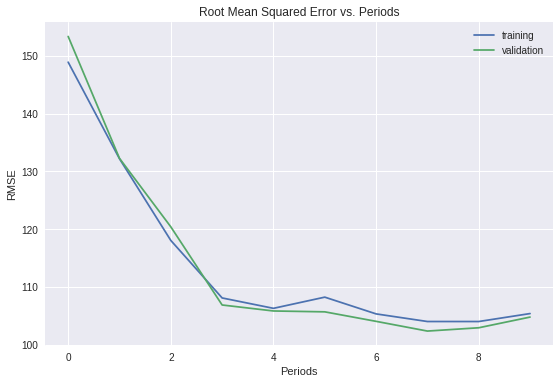

In [8]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 선형 조정
입력값을 -1, 1 범위에 들어오도록 정규화하는 것이 권장되는 표준 방식입니다. 이렇게 하면 SGD에서 한 차원으로 너무 크거나 다른 차원으로 너무 작은 단계를 밟을 때 고착을 방지하는 데 도움이 됩니다. 수치 최적화 분야에 익숙하다면 프리컨디셔너를 사용한다는 개념과 관련이 있음을 알 수 있습니다.

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

 ## 작업 1: 선형 조정을 사용하여 특성 정규화

**입력값을 -1, 1 척도로 정규화합니다.**

**5분 정도 시간을 내어 새로 정규화한 데이터를 학습하고 평가해 보세요.  어느 정도까지 성능을 높일 수 있나요?**

경험적으로 보면, 입력 특성이 대략 같은 척도일 때 NN의 학습 효율이 가장 높습니다.

정규화된 데이터의 상태를 확인하세요.  실수로 특성 하나를 정규화하지 않으면 어떠한 결과가 나타날까요?


Training model...
RMSE (on training data):
  period 00 : 231.20
  period 01 : 207.62
  period 02 : 160.76
  period 03 : 120.95
  period 04 : 117.20
  period 05 : 113.61
  period 06 : 109.61
  period 07 : 104.79
  period 08 : 99.18
  period 09 : 92.72
Model training finished.
Final RMSE (on training data):   92.72
Final RMSE (on validation data): 92.07


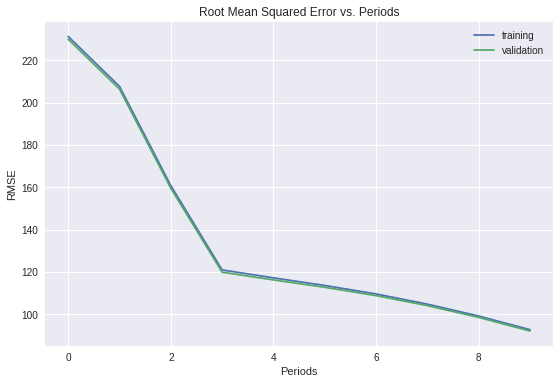

In [10]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## 작업 2: 다른 옵티마이저 사용해 보기

** Adagrad 및 Adam 옵티마이저를 사용하고 성능을 비교합니다.**

대안 중 하나는 Adagrad 옵티마이저입니다. Adagrad의 핵심 개념은 모델의 각 계수에 대해 학습률을 적응적으로 조정하여 유효 학습률을 단조적으로 낮춘다는 것입니다.  이 방식은 볼록 문제에는 적합하지만 비볼록 문제 신경망 학습에는 이상적이지 않을 수 있습니다.  Adagrad를 사용하려면 `GradientDescentOptimizer` 대신 `AdagradOptimizer`를 지정합니다.  Adagrad를 사용하는 경우 학습률을 더 높여야 할 수 있습니다.

비볼록 최적화 문제에 대해서는 Adagrad보다 Adam이 효율적일 수 있습니다.  Adam을 사용하려면 `tf.train.AdamOptimizer` 메소드를 호출합니다. 이 메소드는 선택적으로 몇 가지 초매개변수를 인수로 취하지만 이 솔루션에서는 인수 중 하나(`learning_rate`)만 지정합니다. 프로덕션 설정에서는 선택적 초매개변수를 신중하게 지정하고 조정해야 합니다.

Training model...
RMSE (on training data):
  period 00 : 75.22
  period 01 : 70.11
  period 02 : 68.96
  period 03 : 68.36
  period 04 : 68.78
  period 05 : 66.74
  period 06 : 66.29
  period 07 : 65.99
  period 08 : 65.86
  period 09 : 65.77
Model training finished.
Final RMSE (on training data):   65.77
Final RMSE (on validation data): 63.91


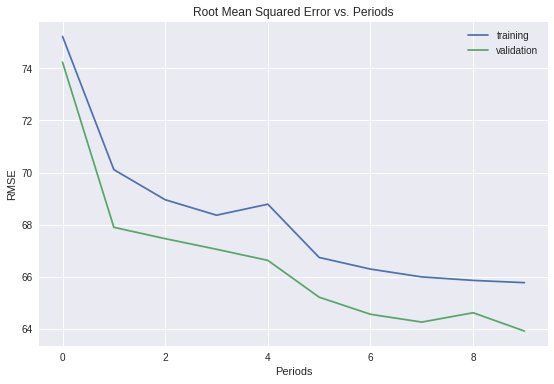

In [12]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.3),
    steps=2000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 76.94
  period 01 : 67.88
  period 02 : 70.62
  period 03 : 67.98
  period 04 : 66.56
  period 05 : 67.65
  period 06 : 68.31
  period 07 : 64.83
  period 08 : 66.32
  period 09 : 65.61
Model training finished.
Final RMSE (on training data):   65.61
Final RMSE (on validation data): 64.74


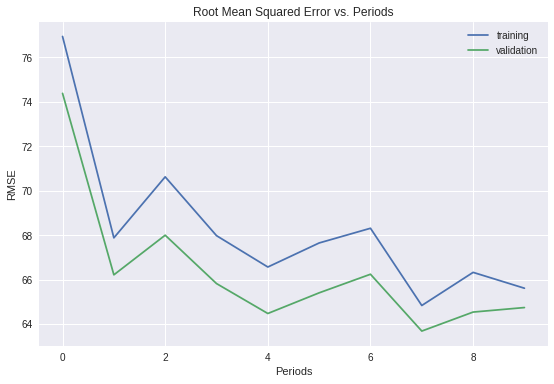

In [13]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.1),
    steps=1000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

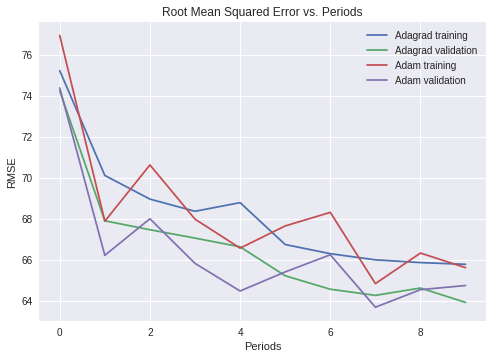

In [14]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

 ## 작업 3: 대안적 정규화 방식 탐색

**다양한 특성에 대안적인 정규화를 시도하여 성능을 더욱 높입니다.**

변환된 데이터의 요약 통계를 자세히 조사해 보면 선형 조정으로 인해 일부 특성이 `-1`에 가깝게 모이는 것을 알 수 있습니다.

예를 들어 여러 특성의 중앙값이 `0.0`이 아닌 `-0.8` 근처입니다.

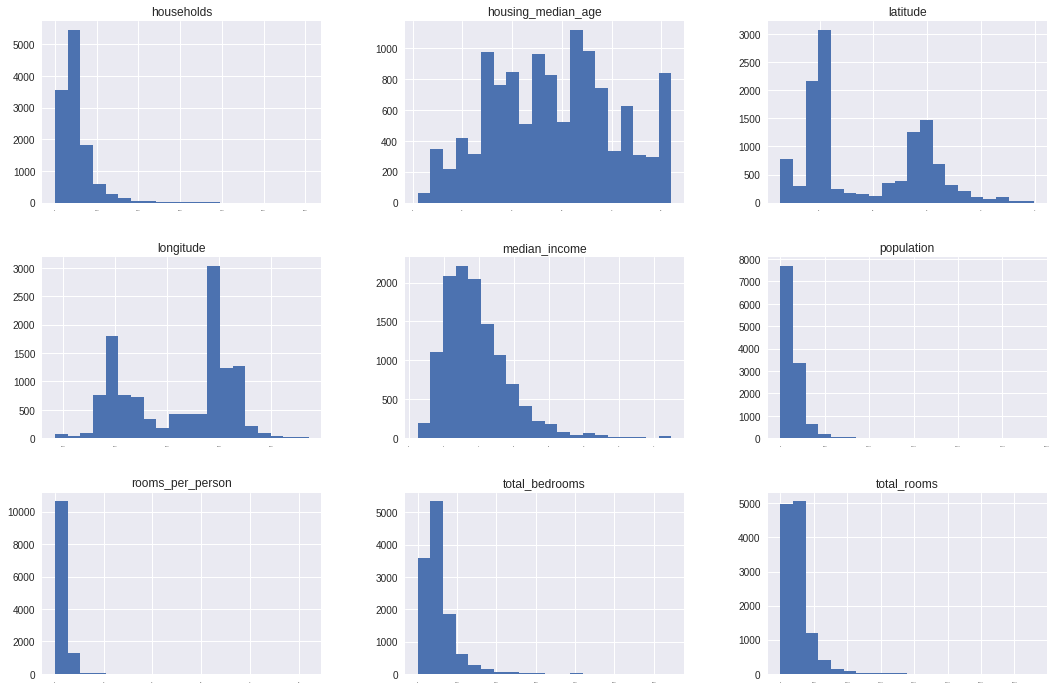

In [15]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=2)

 이러한 특성을 추가적인 방법으로 변환하면 성능이 더욱 향상될 수 있습니다.

예를 들어 로그 조정이 일부 특성에 도움이 될 수 있습니다.  또는 극단값을 잘라내면 척도의 나머지 부분이 더 유용해질 수 있습니다.

In [0]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

 위 블록에는 몇 가지 가능한 정규화 함수가 추가로 포함되어 있습니다. 이러한 함수를 사용하거나 직접 추가해 보세요.

단, 타겟을 정규화하는 경우 예측을 비정규화해야 손실 측정항목을 서로 비교할 수 있습니다.

Training model...
RMSE (on training data):
  period 00 : 67.31
  period 01 : 80.37
  period 02 : 75.11
  period 03 : 78.76
  period 04 : 69.13
  period 05 : 69.87
  period 06 : 65.78
  period 07 : 66.86
  period 08 : 66.02
  period 09 : 66.18
Model training finished.
Final RMSE (on training data):   66.18
Final RMSE (on validation data): 64.77


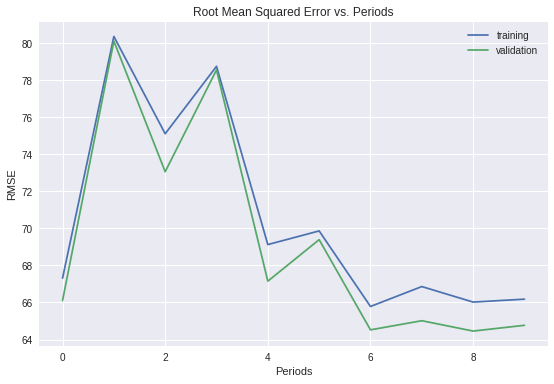

In [18]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.1),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## 선택 과제: 위도 및 경도 특성만 사용

**특성으로 위도와 경도만 사용하는 NN 모델을 학습시킵니다.**

부동산 업계에서는 오로지 입지만이 주택 가격을 결정하는 중요한 요소라고 말합니다.
특성으로 위도와 경도만 사용하는 모델을 학습시켜 이 주장을 검증해 보겠습니다.

이 방법이 성공하려면 NN이 위도 및 경도로부터 복잡한 비선형성을 학습할 수 있어야 합니다.

**NOTE:** 실습 앞부분에서 충분했던 것보다 더 많은 레이어를 포함하는 네트워크 구조가 필요할 수 있습니다.

Training model...
RMSE (on training data):
  period 00 : 99.48
  period 01 : 95.21
  period 02 : 95.22
  period 03 : 93.27
  period 04 : 93.65
  period 05 : 93.21
  period 06 : 92.28
  period 07 : 91.94
  period 08 : 91.58
  period 09 : 91.59
Model training finished.
Final RMSE (on training data):   91.59
Final RMSE (on validation data): 90.60


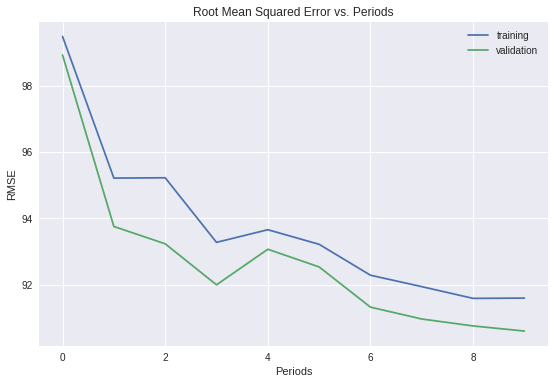

In [20]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.1),
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10, 7, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)